# Analysis of the effect of ethnicity on food consumption in London

- Does ethnic diversity have an effect on food consumption at area level? And if yes, what is its nature?
- To which extent is the ethnic diversity responsible for the food consumption diversity of some aliment categories?
- Can we attribute particular food habits to specific ethnic groups?

The objective is to extend the Tesco dataset with a dataset containing numerous interesting socio-economic statistics in the London area. The analysis focuses on LSOA regions, which is the finest resolution available in the Tesco dataset. The proportion of inhabitants from various ethnicities is given for each LSOA in the additional dataset. We will first analyze the effect of ethnic diversity on food consumption. It will be based on the comparison of diversity of food categories consumed across LSOA regions and their ethnic diversity. We will then try to validate the observations we made by assessing if they still hold when other socio-economic aspects (such as mean wage for example) are taken into account. Depending on the results found, we will also investigate in greater details what impact specific ethnic populations may have on the food consumption.

## Table of content 

## 1. Set the environment and perform exploratory analysis

### Import the packages 

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import plotly
import plotly.express as px
import scipy
from scipy.stats import spearmanr
import os

### Define the paths of the different datasets use for the analysis
Three main datasets are used for this project:
- **Tesco dataset**: besides the nutrients information used in the validation analysis of the paper, this dataset offers information on the purchases of different products at the area level. It's those information that will be used in our project at the LSOA level. 
- **Socio-economic dataset of the LSOA**: this dataset provides socio-economic information at the LSOA level. Combining this dataset with the Tesco one will allow us to put into perspective the ethnicity of the population with their food consumption. 
- **Geographical information dataset of the LSOA**: this dataset will be used for visualization purposes as it will allow to display some of the results on the London map with relevant values assigned to each geographical region representing the LSOA. 

In [2]:
GEO_LSOA_PATH = os.getcwd() + '/data/Geo_data/LSOA_2011_London_gen_MHW.shp'
TESCO_PATH = os.getcwd() + '/data/Area_level_data/year_lsoa_grocery.csv'
SOCIO_ECO_LSOA_PATH = os.getcwd() + '/data/lsoa-data.csv'

### Define some functions that will be used throughout the project
The roles of the functions define below are the following:
- `load_merge_clean_data()`: this function takes as input the paths of the three datasets used in this project. It will load those different datasets and process them to return one single dataset containing the information of the three datasets of interest.
- `plot_map()`: this function allows to display a feature on the London map with its values assigned to each geographical region representing the LSOA. It takes as input the dataframe considered (that should contain the geographical information) as well as the name of the feature to be plotted on the map, if this feature is part of the dataframe, OR the feature array can directly be given as an input as well. 

In [3]:
###############################################################################################################
#############################     Load merge and clean function      ##########################################
###############################################################################################################

def load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH):
    '''
    This function load the different datasets used for the analysis,
    clean and merge those datasets together to obtain as an output one single panda dataframe
    with the socio-economic, the Tesco and the geography information of each LSOA
    '''
    # load the data with the geography information of each LSOA
    map_df = gpd.read_file(GEO_LSOA_PATH)
    # set the index of this dataframe to the code of each LSOA to facilitate the merge of the dataframes
    map_df.index = map_df['LSOA11CD']
    
    # load the data with the Tesco information of each LSOA
    data_df = pd.read_csv(TESCO_PATH)
    
    # merge the Tesco dataframe with the one with the geo information of the corresponding regions  
    merged_map_df = map_df.join(data_df.set_index('area_id'))
    
    # convert coordinates that are in UTM format into latitude longitude (to plot the results on a map)
    merged_map_df = merged_map_df.to_crs({'init': 'epsg:4326'}) # cause of the warning
    
    # load the data with the socio-economic information of each LSOA
    lsoa_df = pd.read_csv(SOCIO_ECO_LSOA_PATH, encoding = "ISO-8859-1", engine='python')
    # drop the last 2 rows that are full of nan (due to the format of the title of the columns (3 rows))
    lsoa_df.drop(lsoa_df.tail(2).index,inplace=True)
    
    # merge the merged dataframe with  the socio-economic dataframe of the corresponding regions  
    merged_map_lsoa_df = merged_map_df.join(lsoa_df.set_index('Lower Super Output Area'))
    
    # set the index of this dataframe to the name of each LSOA to obtain more comprehensive data
    merged_map_lsoa_df.index = merged_map_lsoa_df['LSOA11NM']
    
    # remove the rows for which we don't have data everywhere 
    # consider the feature of population to determine where we lack some information
    population = np.array((merged_map_lsoa_df['population'])) 
    merged_map_lsoa_df = merged_map_lsoa_df[np.logical_not(np.isnan(population))]
    
    
    # REMOVE SPACES IN COLUMN NAMES
    merged_map_lsoa_df.columns = merged_map_lsoa_df.columns.str.replace(' ', '_')
    
    # return this final merged and cleaned dataset
    return merged_map_lsoa_df


###############################################################################################################
#####################################     Plot functions     ##################################################
###############################################################################################################

def plot_map(dataframe, name_feature, color = 'magma', opacity = 0.9):
    '''
    plot the feature of the dataframe on the London map
    '''
    fig = px.choropleth_mapbox(dataframe,
                               geojson=dataframe.geometry,
                               locations=dataframe.index,
                               color=name_feature,
                               center={"lat": 51.49, "lon": -0.127},
                               mapbox_style="carto-positron",
                               opacity = opacity,
                               color_continuous_scale = color, # https://plotly.com/python/colorscales/   
                               # magma, viridis
                               zoom=9)

    fig.update_layout(height = 500, margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

### Create the dataframe with all the information of the three datasets of interest

In [4]:
full_df = load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH)
full_df.head(5)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Road_Casualties;2012;Slight,Road_Casualties;2012;2012_Total,Road_Casualties;2013;Fatal,Road_Casualties;2013;Serious,Road_Casualties;2013;Slight,Road_Casualties;2013;2013_Total,Road_Casualties;2014;Fatal,Road_Casualties;2014;Serious,Road_Casualties;2014;Slight,Road_Casualties;2014;2014_Total
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
City of London 001A,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,14.0,16.0,0.0,3.0,10.0,13.0,0.0,2.0,10.0,12.0
City of London 001B,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,8.0,9.0,0.0,1.0,5.0,6.0,0.0,0.0,9.0,9.0
City of London 001C,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
City of London 001E,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,22.0,24.0,0.0,5.0,15.0,20.0,1.0,0.0,20.0,21.0
Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,3.0,3.0


In [5]:
for col in full_df.columns:
    print(col)

LSOA11CD
LSOA11NM
MSOA11CD
MSOA11NM
LAD11CD
LAD11NM
RGN11CD
RGN11NM
USUALRES
HHOLDRES
COMESTRES
POPDEN
HHOLDS
AVHHOLDSZ
geometry
weight
weight_perc2.5
weight_perc25
weight_perc50
weight_perc75
weight_perc97.5
weight_std
weight_ci95
volume
volume_perc2.5
volume_perc25
volume_perc50
volume_perc75
volume_perc97.5
volume_std
volume_ci95
fat
fat_perc2.5
fat_perc25
fat_perc50
fat_perc75
fat_perc97.5
fat_std
fat_ci95
saturate
saturate_perc2.5
saturate_perc25
saturate_perc50
saturate_perc75
saturate_perc97.5
saturate_std
saturate_ci95
salt
salt_perc2.5
salt_perc25
salt_perc50
salt_perc75
salt_perc97.5
salt_std
salt_ci95
sugar
sugar_perc2.5
sugar_perc25
sugar_perc50
sugar_perc75
sugar_perc97.5
sugar_std
sugar_ci95
protein
protein_perc2.5
protein_perc25
protein_perc50
protein_perc75
protein_perc97.5
protein_std
protein_ci95
carb
carb_perc2.5
carb_perc25
carb_perc50
carb_perc75
carb_perc97.5
carb_std
carb_ci95
fibre
fibre_perc2.5
fibre_perc25
fibre_perc50
fibre_perc75
fibre_perc97.5
fibre_std
fib

## Computation of new features

new entropies

In [6]:
def compute_entropies(df, f_col_list):
    
    f_df = df[f_col_list]
    n_col = len(f_col_list)
        
    h_df = pd.DataFrame()
    
    # compute intermediates values inside the sum of eq (12)
    for col in f_df.columns:
        col_val = f_df[col] * np.log2(f_df[col])
        h_df.insert(len(h_df.columns), col, col_val, True)
    
    # compute the entropy as the sum of the intermediates values
    h = - h_df.sum(axis=1)
    h_df.insert(0, 'h', h, True)

    # remove all the intermediate values from the dataframe
    h_df = h_df.iloc[:, :1]

    # normalization
    h_df['h_norm'] = h_df['h'] / np.log2(n_col)
    
    return h_df['h'].values, h_df['h_norm'].values

To make a difference between food and drinks, in addition to the already present h_items, we compute two new category entropies taking only part of the items in consideration h_food and h_drink with their normalizer conterparts

In [7]:
food_col_list = ['f_dairy',
                 'f_eggs',
                 'f_fats_oils',
                 'f_fish',
                 'f_fruit_veg',
                 'f_grains',
                 'f_meat_red',
                 'f_poultry',
                 'f_readymade',
                 'f_sauces',
                 'f_sweets']

h_items_food, h_items_food_norm = compute_entropies(full_df, food_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('h_items') 
full_df.insert(new_h_idx, 'h_items_food_norm', h_items_food_norm.tolist(), True)
full_df.insert(new_h_idx, 'h_items_food', h_items_food.tolist(), True)

In [8]:
drink_col_list = ['f_beer',
                  'f_soft_drinks',
                  'f_spirits',
                  'f_tea_coffee',
                  'f_water',
                  'f_wine']

h_items_drink, h_items_drink_norm = compute_entropies(full_df, drink_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('h_items') 
full_df.insert(new_h_idx, 'h_items_drink_norm', h_items_drink_norm.tolist(), True)
full_df.insert(new_h_idx, 'h_items_drink', h_items_drink.tolist(), True)

We then compute an entropy of the diverse ethnic groups in each area to get a sense of the racial diversity of the area

For our entropy computation, we need the representation of each ethnic groups to be described as a probability between 0 and 1 instead of a percentage value, we will modify those columns accordingly in the dataframe

In [9]:
# divide by 100 not to have them in a percent format for entropy computation
full_df.loc[:, 'Ethnic_Group;White_(%);2011':'Ethnic_Group;Other_ethnic_group_(%);2011'] /= 100


# Those are not % anymore, rename them with naming convention coherent with the naming scheme in Tesco data
old_names = ['Ethnic_Group;White_(%);2011',
             'Ethnic_Group;Mixed/multiple_ethnic_groups_(%);2011',
             'Ethnic_Group;Asian/Asian_British_(%);2011',
             'Ethnic_Group;Black/African/Caribbean/Black_British_(%);2011',
             'Ethnic_Group;Other_ethnic_group_(%);2011']

new_names = ['Ethnic_Group;f_White;2011',
             'Ethnic_Group;f_Mixed/multiple_ethnic_groups;2011',
             'Ethnic_Group;f_Asian/Asian_British;2011',
             'Ethnic_Group;f_Black/African/Caribbean/Black_British;2011',
             'Ethnic_Group;f_Other_ethnic_group;2011']
rename_dict = dict(zip(old_names, new_names))
full_df.rename(columns = rename_dict, inplace = True)

h_ethnicity, h_ethnicity_norm = compute_entropies(full_df, new_names)

# insert two new columns
new_h_idx = full_df.columns.get_loc('Country_of_Birth;United_Kingdom;2011') 
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities_norm;2011', h_ethnicity_norm.tolist(), True)
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities;2011', h_ethnicity.tolist(), True)

/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Filter by representativity

To keep only the most representative areas for our analysis, we filter the dataset by representativity score as described in the Tesco paper

In [10]:
repr_df = full_df[full_df['representativeness_norm'] > 0.3]
print(repr_df.shape)
#repr_df.head(5)

(749, 498)


# Correlation analysis

To begin our analysis, we compute the correlations between the ethnicity and the product categories at different level of granularity. We used spearman rank correlation.

- Correlation between h_ethnicity_norm and h_food_norm, h_drink_norm
- Correlation between the different proportions of ethnic groups and h_food_norm, h_drink_norm
- Correlation between the different propotrions of ethnic groups and different propotrions of items gategory

## Correlation between h_ethnicity_norm and h_food_norm, h_drink_norm

In [11]:
h_ethnicity = repr_df['Ethnic_Group;h_ethnicities_norm;2011'].values
h_items_food = repr_df['h_items_food_norm'].values
h_items_drink = repr_df['h_items_drink_norm'].values

rho_food, p_food = spearmanr(h_ethnicity, h_items_food)
rho_drink, p_drinks = spearmanr(h_ethnicity, h_items_drink)

d = {'Category': ['food', 'drink'],
     'R': [rho_food, rho_drink],
     'p-value': [p_food, p_drinks]}
hh_corr_df = pd.DataFrame(data=d)
hh_corr_df

,Category,R,p-value
0,food,0.127450,4.714695e-04
1,drink,0.206212,1.230239e-08


### Visualization

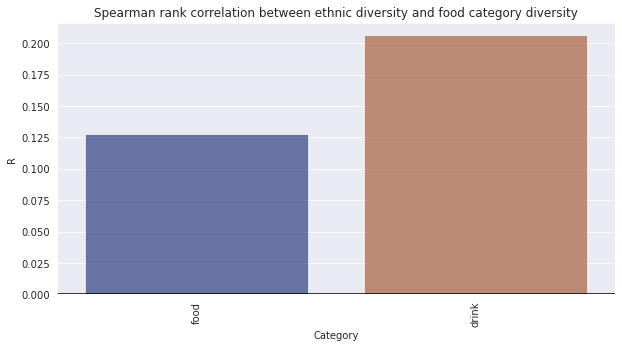

In [12]:
# keep only the significant data
hh_plot_df = hh_corr_df[hh_corr_df['p-value'] < 0.05]

sns.set_style("dark")

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Category', y='R', data=hh_plot_df, palette='dark', alpha=.6)
ax.grid(axis='y')
ax.set_ylabel('R')
plt.xticks(rotation=90 )
ax.axhline(y=0, color='k', linestyle='-')
ax.set_title('Spearman rank correlation between ethnic diversity and food category diversity')
plt.show()

## Correlation between the different proportions of ethnic groups and h_food_norm, h_drink_norm

In [13]:
f_ethnicity_idx_lo = repr_df.columns.get_loc('Ethnic_Group;f_White;2011')
f_ethnicity_idx_hi = repr_df.columns.get_loc('Ethnic_Group;f_Other_ethnic_group;2011')+1

# list containing the name of the ethnic groups
ethnicity_col = np.array(repr_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) 
n_ethnicity = ethnicity_col.shape[0]

# list containing the name of the item categories (food or drink)
category_col = np.array(['food',
                         'drink'])
n_category = category_col.shape[0]

# repeat elements to have same length and suitable format
ethnicity_col = np.repeat(ethnicity_col, n_category)
category_col = np.tile(category_col, n_ethnicity)

# list containing the values of the ethnic group representations
f_ethnicities = []
for col in repr_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(repr_df[col].values)

# list containing the values of items entropy for food and drink
h_items_food = repr_df['h_items_food_norm'].values
h_items_drink = repr_df['h_items_drink_norm'].values
h_item_categories = [h_items_food, h_items_drink]

# compute the correlation and their p-values
R_col = []
p_col = []
for et in f_ethnicities:
    for cat in h_item_categories:
        R, p = spearmanr(et, cat)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnicity_col.tolist(),
     'Category': category_col.tolist(),
     'R': R_col,
     'p-value': p_col}

fh_corr_df = pd.DataFrame(data = d)
fh_corr_df

,Ethnicity,Category,R,p-value
0,Ethnic_Group;f_White;2011,food,0.094062,1.000388e-02
1,Ethnic_Group;f_White;2011,drink,-0.088947,1.489015e-02
2,Ethnic_Group;f_Mixed/multiple_ethnic_groups;2011,food,0.354019,1.552519e-23
3,Ethnic_Group;f_Mixed/multiple_ethnic_groups;2011,drink,0.360424,2.150611e-24
4,Ethnic_Group;f_Asian/Asian_British;2011,food,-0.435901,4.370948e-36
5,Ethnic_Group;f_Asian/Asian_British;2011,drink,-0.313221,1.638651e-18
6,Ethnic_Group;f_Black/African/Caribbean/Black_B...,food,0.379756,4.173757e-27
7,Ethnic_Group;f_Black/African/Caribbean/Black_B...,drink,0.431083,3.017275e-35
8,Ethnic_Group;f_Other_ethnic_group;2011,food,-0.011311,7.572808e-01
9,Ethnic_Group;f_Other_ethnic_group;2011,drink,-0.038097,2.977484e-01


### Visualization

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Ethnic_Group;f_White;2011'),
  Text(1, 0, 'Ethnic_Group;f_Mixed/multiple_ethnic_groups;2011'),
  Text(2, 0, 'Ethnic_Group;f_Asian/Asian_British;2011'),
  Text(3, 0, 'Ethnic_Group;f_Black/African/Caribbean/Black_British;2011')])

<Figure size 720x360 with 0 Axes>

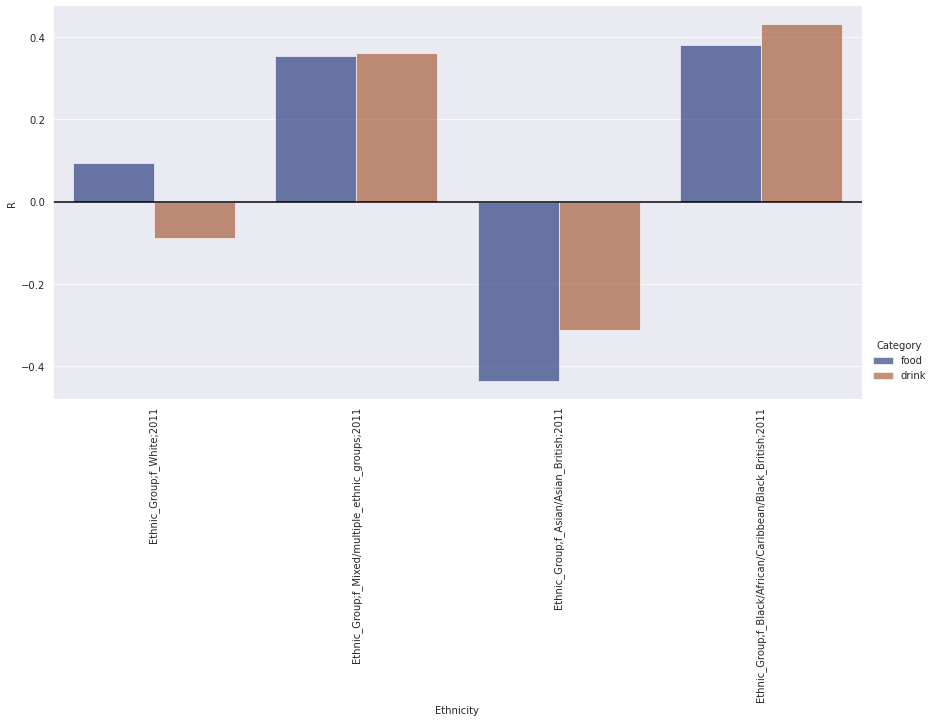

In [14]:
# keep only the significant data 
fh_plot_df = fh_corr_df[fh_corr_df['p-value'] < 0.05]

sns.set_style("dark")

plt.figure(figsize=(10,5))
g = sns.catplot(data=fh_plot_df, kind="bar", x="Ethnicity", y="R", hue="Category", palette="dark", alpha=.6, height=6, aspect=2)
for ax in g.axes.flat:
    ax.grid(True, axis='y')
ax.axhline(y=0, color='k')
plt.xticks(rotation=90 )

## Correlation between the different propotrions of ethnic groups and different propotrions of items gategory

In [15]:
# list containing names of the different products proportions
f_items_idx_lo = repr_df.columns.get_loc('f_beer') 
f_items_idx_hi = repr_df.columns.get_loc('f_wine')+1
item_col = np.array(repr_df.columns[f_items_idx_lo:f_items_idx_hi]) # list containing name of the columns
n_item = item_col.shape[0]

# list containing names of the different ethnic groups
f_ethnicity_idx_lo = repr_df.columns.get_loc('Ethnic_Group;f_White;2011')
f_ethnicity_idx_hi = repr_df.columns.get_loc('Ethnic_Group;f_Other_ethnic_group;2011')+1
ethnicity_col = np.array(repr_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) # list containing name of the columns
n_ethnicity = ethnicity_col.shape[0]

# repeat elements to get good format
item_col = np.tile(item_col, n_ethnicity)
ethnicity_col = np.repeat(ethnicity_col, n_item)


f_items = []
for col in repr_df.iloc[:, f_items_idx_lo:f_items_idx_hi].columns:
    f_items.append(repr_df[col].values)

f_ethnicities = []
for col in repr_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(repr_df[col].values)
    
R_col = []
p_col = []

for et in f_ethnicities:
    for item in f_items:
        R, p = spearmanr(et, item)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnicity_col.tolist(),
     'Item': item_col.tolist(),
     'R': R_col,
     'p-value': p_col}
      
ff_corr_df = pd.DataFrame(data = d)

# add a "Category column" to label items as food or drink
def is_food_or_drink(Item):
    
    food_list = set(['f_dairy',
                     'f_eggs',
                     'f_fats_oils',
                     'f_fish',
                     'f_fruit_veg',
                     'f_grains',
                     'f_meat_red',
                     'f_poultry',
                     'f_readymade',
                     'f_sauces',
                     'f_sweets'])

    drink_list = set(['f_beer',
                      'f_soft_drinks',
                      'f_spirits',
                      'f_tea_coffee',
                      'f_water',
                      'f_wine'])
    
    if Item in food_list :
        return "food"
    elif Item in drink_list :
        return "drink"

ff_corr_df.insert(1, 'Category', ff_corr_df['Item'].apply(is_food_or_drink), True)
ff_corr_df

,Ethnicity,Category,Item,R,p-value
0,Ethnic_Group;f_White;2011,drink,f_beer,0.350928,3.966217e-23
1,Ethnic_Group;f_White;2011,food,f_dairy,-0.256853,9.479161e-13
2,Ethnic_Group;f_White;2011,food,f_eggs,-0.293693,2.287377e-16
3,Ethnic_Group;f_White;2011,food,f_fats_oils,-0.269373,6.435171e-14
4,Ethnic_Group;f_White;2011,food,f_fish,0.218330,1.557980e-09
...,...,...,...,...,...
80,Ethnic_Group;f_Other_ethnic_group;2011,drink,f_spirits,0.120880,9.168861e-04
81,Ethnic_Group;f_Other_ethnic_group;2011,food,f_sweets,-0.096084,8.505883e-03
82,Ethnic_Group;f_Other_ethnic_group;2011,drink,f_tea_coffee,0.373080,3.783774e-26
83,Ethnic_Group;f_Other_ethnic_group;2011,drink,f_water,0.304247,1.660721e-17


### Visualization

heatmaps

<ipython-input-16-0bbac62d3d29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['R'][plot_df['p-value'] >= 0.05] = 0


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'f_White'),
  Text(0, 1.5, 'f_Mixed/multiple_ethnic_groups1'),
  Text(0, 2.5, 'f_Asian/Asian_British'),
  Text(0, 3.5, 'f_Black/African/Caribbean/Black_British'),
  Text(0, 4.5, 'f_Other_ethnic_group')])

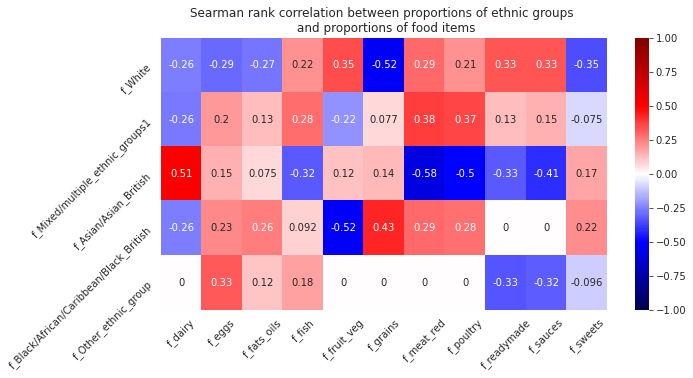

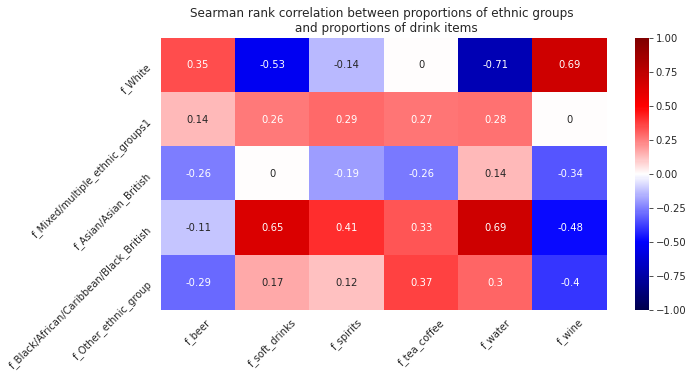

In [16]:
plot_df = ff_corr_df.copy()
plot_df['R'][plot_df['p-value'] >= 0.05] = 0
plot_df

ethnicity_list = np.array(repr_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]).tolist()
n_ethnicity = len(ethnicity_list)
n_food = 11
n_drink = 6

R_food_np = np.zeros((n_ethnicity, n_food))
R_drink_np = np.zeros((n_ethnicity, n_drink))

for i in range(n_ethnicity):
    R_food_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'food')]
    R_drink_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'drink')]


ethnicities_list = ['f_White',
                    'f_Mixed/multiple_ethnic_groups1',
                    'f_Asian/Asian_British',
                    'f_Black/African/Caribbean/Black_British',
                    'f_Other_ethnic_group']    
    
food_list = ['f_dairy',
             'f_eggs',
             'f_fats_oils',
             'f_fish',
             'f_fruit_veg',
             'f_grains',
             'f_meat_red',
             'f_poultry',
             'f_readymade',
             'f_sauces',
             'f_sweets']

drink_list = ['f_beer',
              'f_soft_drinks',
              'f_spirits',
              'f_tea_coffee',
              'f_water',
              'f_wine']

plt.figure(figsize=(10,5))
ax = sns.heatmap(R_food_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Searman rank correlation between proportions of ethnic groups \n and proportions of food items')
ax.set_xticklabels(food_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)


plt.figure(figsize=(10,5))
ax = sns.heatmap(R_drink_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Searman rank correlation between proportions of ethnic groups \n and proportions of drink items')
ax.set_xticklabels(drink_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)

In [19]:
import statsmodels.formula.api as smf

"""h_items_norm
Ethnic Group;h_ethnicities_norm;2011
Household Income, 2011/12;Mean Annual Household Income estimate (£)
Household Income, 2011/12;Median Annual Household Income estimate (£)
"""


# this time we can use the formula to make it more understandable
mod = smf.logit(formula="h_items_norm ~ Ethnic_Group;h_ethnicities_norm;2011", data=full_df)
res = mod.fit()
print(res.summary())

PatsyError: Error evaluating factor: SyntaxError: invalid syntax (<string>, line 1)
    h_items_norm ~ Ethnic_Group;h_ethnicities_norm;2011
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^